# Final Project | Prediction possibilities in a pandemic 
by Kevin Spurk

# Introduction

In this analysis I'm investigating the Covid 19 pandemic and have a look at the prediction opportunities of specific metrics such as the number of new daily cases and new daily deaths. The goal is to find out how well you can predict those metrics for a date in the future based on past and present data, comparing the prediction performance of two different datasets. One provides data of peoples movement patterns in areas such as retail, parks, public transport, etc. The other reflects search patterns of keywords connected to the pandemic and someone with a potential Covid infection experiencing symptoms might look for online. The I’m using data of 13 European countries to allow for a cross-country and a by-country analysis and prediction.

# Table of content

**1. Setup**

Importing libraries and datasets

**2. Data wrangling**

Initial elimination of  unnecessary features, data cleaning and wrangling.

**3. EDA**

Statistical and visual exploration of the data.

**4. Data Preprocessing**

Feature selection and using techniques like encoding and time lags to prepare the data for modeling.

**5. Baseline model**

Creating a first prediction model based on the mobility data and evaluate its performance to compare against further improvements and alternative model algorithms.

**6. Mobility data model**

Developing the prediction model based on the mobility data. Applying feature transformations, using hyper parameter tuning and different model algorithms and comparing the results of different approaches.

**7. Search trends data model**

Developing the prediction model based on the search trends data equivalent to the previous step.

**8. Model with combined data**

Checking if a model using both data sets can have better prediction performance.

**9. Conclusions**

A comparative summary of the modelling results and a recommendation for next step to take when trying to predict the metrics of the Covid 19 pandemic.


# 1 | Setup

### 1.1 Libary imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
import random
import datetime
import time
from datetime import date, timedelta
import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = None
pd.set_option('max_row', None)

### 1.2 Data imports

### 1.2.1 Google mobility trend data


In [2]:
# csv import
data_mob_global = pd.read_csv('data/mobility_google/Global_Mobility_Report.csv')

data_mob_global.head(2)

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,place_id,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-15,0.0,4.0,5.0,0.0,2.0,1.0
1,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-16,1.0,4.0,4.0,1.0,2.0,1.0
2,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-17,-1.0,1.0,5.0,1.0,2.0,1.0
3,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-18,-2.0,1.0,5.0,0.0,2.0,1.0
4,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-19,-2.0,0.0,4.0,-1.0,2.0,1.0


The google mobility dataset provides information about the movement patterns of people based to location data of Android mobile phones. The columns containing this information show the percentage difference Android user frequency compared to a baseline value (the median value, for the corresponding day of the week, during the 5-week period Jan 3–Feb 6, 2020) on a given day at a specific type of location. Locations are clustered into retail and recreation, grocery and pharmacy, parks, transit stations, workplace, residential. Columns for location and time data are also present. The dataset includes information of over 100 countries, and in parts regions of countries from February 2020 until November 2021.

The data is supposed to serve as a proxy for how populated these location clusters are, to find out if there is a statistically significant relationship between population and Covid 19 metrics and if you can build a prediction model with them in the coming steps.

In [3]:
data_mob_global.shape

(7697738, 15)

In [4]:
data_mob_global.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7697738 entries, 0 to 7697737
Data columns (total 15 columns):
 #   Column                                              Dtype  
---  ------                                              -----  
 0   country_region_code                                 object 
 1   country_region                                      object 
 2   sub_region_1                                        object 
 3   sub_region_2                                        object 
 4   metro_area                                          object 
 5   iso_3166_2_code                                     object 
 6   census_fips_code                                    float64
 7   place_id                                            object 
 8   date                                                object 
 9   retail_and_recreation_percent_change_from_baseline  float64
 10  grocery_and_pharmacy_percent_change_from_baseline   float64
 11  parks_percent_change_from_baseline   

### 1.2.3 google trends data

With the DeepL API I’m translating a list of 21 keywords connected to the pandemic into different language to check for there google search popularity in 13 European countries. I picked 21 keywords such as ‘covid’, ‘PCR’, ‘headache’ and other symptoms of SARS-CoV-2 under the assumption that an infected person experiencing symptoms would use them in a online search.

In [9]:
# import libaries to connect to google and deepL APIs 
from pytrends.request import TrendReq
from pytrends import dailydata
from translate import Translator 

# get authentification for deepL API
with open('auth/deepl_auth_key.txt') as f:
    deepl_auth_key = f.read()

# google trends API access request
pytrends = TrendReq(hl='en-US', tz=0)

In [10]:
from pyf.apis import deepl_translate_list
from pyf.imex import df_to_csv_format

# keyword list 
keywords_list = ['covid', 'corona', 'SARS-CoV-2', 'virus', 'symptoms', 'fever', 'cough', 'tiredness', 'loss of smell', 'throat', 'shortness of breath', 'breathing issues', 'headache', 'diarrhea', 'chest pain', 'PCR', 'corona test', 'covid test', 'test', 'sick', 'infection']

# dict of countries and there languages to search in
countries_lang = {'GB': 'en', 'DE': 'de', 'FR': 'fr', 'NL': 'nl',
                  'ES': 'es', 'PT': 'pt', 'PL': 'pl', 'IT': 'it',
                  'AT': 'de', 'DK': 'da', 'SE': 'sv', 'GR': 'el',
                  'CZ': 'cs'}

# translating keyword list into target languages
# c19_kw_dict, c19_kw_df = deepl_translate_list(auth=deepl_auth_key, keywords=keywords_list, lang_out=countries_lang)

# export translations to csv
# df_to_csv_format(c19_kw_df, 'keywords_translations', 'full')

c19_kw_df = pd.read_csv('data/multilanguage/keywords_translations_full.csv')


In [11]:
c19_kw_df

,GB,DE,FR,NL,ES,PT,PL,IT,AT,DK,SE,GR,CZ
0,covid,covid,covide,covid,covid,covid,covid,covid,covid,covid,covid,covid,covid
1,corona,corona,corona,corona,corona,corona,korona,corona,corona,corona,corona,corona,corona
2,SARS-CoV-2,SARS-CoV-2,SRAS-CoV-2,SARS-CoV-2,SARS-CoV-2,SRA-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2
3,virus,Virus,virus,virus,virus,vírus,wirus,virus,Virus,virus,virus,ιός,virus
4,symptoms,Symptome,symptômes,symptomen,síntomas,sintomas,objawy,sintomi,Symptome,symptomer,symtom,συμπτώματα,příznaky
5,fever,Fieber,fièvre,koorts,fiebre,febre,gorączka,febbre,Fieber,feber,feber,πυρετός,horečka
6,cough,Husten,toux,hoest,toser,tosse,kaszel,tosse,Husten,hoste,hosta,βήχας,kašel
7,tiredness,Müdigkeit,fatigue,vermoeidheid,cansancio,cansaço,zmęczenie,stanchezza,Müdigkeit,træthed,trötthet,κούραση,únava
8,loss of smell,Geruchsverlust,la perte de l'odorat,verlies van reukzin,pérdida del olfato,perda do olfacto,utrata węchu,perdita dell'olfatto,Geruchsverlust,tab af lugt,förlust av lukt,απώλεια οσμής,ztráta čichu
9,throat,Kehle,gorge,keel,garganta,garganta,gardło,gola,Kehle,hals,hals,λαιμός,krk


This data frame is a overview of the dictionary that holds the target countries with their respective keywords.

I’m using the google API to get data for the popularity of the keywords between march 2020 and October 2021.

In [13]:
'''
from pyf.apis import g_trends_ml

# get google trends data for keywords in all languages
data_g_trends = g_trends_ml(kw_dict=c19_kw_df, dt_start='2020-03', dt_end='2021-10', sleep_time=600)

'''

"\n# get google trends data for keywords in all languages\ndata_g_trends = g_trends_ml(kw_dict=c19_kw_df, dt_start='2020-03', dt_end='2021-10', sleep_time=600)\n\n"

In [14]:
import glob
from pyf.imex import import_concat_csv

# import google trends data from csv files
data_g_trends = import_concat_csv('data/keywords_google/', 'g_trend_2020-03_2021-10_GB')
     

In [15]:
data_g_trends.head(2)

,date,covid,corona,SARS-CoV-2,virus,symptoms,fever,cough,tiredness,loss of smell,throat,shortness of breath,breathing issues,headache,diarrhea,chest pain,PCR,corona test,covid test,test,sick,infection,location
0,2020-03-01,0.25,6.27,1.52,10.75,23.01,13.94,5.20,33.58,0.00,13.94,11.22,0.0,21.28,45.54,31.90,0.16,0.60,0.0,22.40,13.50,59.64,GB
1,2020-03-02,0.35,8.58,2.80,14.62,28.91,14.76,5.46,31.39,0.00,14.35,13.86,0.0,20.72,44.16,20.88,0.60,2.04,0.0,28.16,13.50,65.52,GB
2,2020-03-03,0.35,8.91,0.00,14.62,29.50,11.89,5.98,45.99,0.04,14.35,9.57,0.0,24.08,53.13,28.42,0.52,2.04,0.0,29.44,14.40,59.64,GB
3,2020-03-04,0.50,10.89,1.44,18.06,30.09,10.25,5.20,45.99,0.00,14.76,7.92,0.0,25.20,53.13,22.62,0.30,2.64,0.0,27.52,22.95,67.20,GB
4,2020-03-05,0.50,12.21,0.00,18.92,28.91,13.53,5.20,35.77,0.00,14.76,11.55,0.0,22.40,48.99,16.82,0.92,2.04,0.0,27.84,14.85,65.52,GB


In [16]:
data_g_trends.shape

7930

The resulting dataframe gives a value for the daily keyword popularity in each country. The values range from 0 to 100 representing the highest search count over all keywords in that time period and all other search counts scaled to that value. The data fetched is from march 2020 until october 2021.

In the coming steps I’m exploring if there is a statistically significant relationship between keyword search popularity and Covid 19 metrics and if you can build a prediction model with them.


### 1.2.4 twitter trends data

In [17]:
import tweepy as tw 
from pyf.apis import tweepy_auth

# get authentification for twitter API
tw_api, tw_client = tweepy_auth('auth/tw_auth.txt')

Authentication OK


In [18]:
tweets = tw_client.get_recent_tweets_count(query='winter', granularity='day')
tweets

Response(data=[{'end': '2021-11-27T00:00:00.000Z', 'start': '2021-11-26T20:07:45.000Z', 'tweet_count': 30747}, {'end': '2021-11-28T00:00:00.000Z', 'start': '2021-11-27T00:00:00.000Z', 'tweet_count': 295066}, {'end': '2021-11-29T00:00:00.000Z', 'start': '2021-11-28T00:00:00.000Z', 'tweet_count': 346594}, {'end': '2021-11-30T00:00:00.000Z', 'start': '2021-11-29T00:00:00.000Z', 'tweet_count': 391358}, {'end': '2021-12-01T00:00:00.000Z', 'start': '2021-11-30T00:00:00.000Z', 'tweet_count': 408485}, {'end': '2021-12-02T00:00:00.000Z', 'start': '2021-12-01T00:00:00.000Z', 'tweet_count': 338643}, {'end': '2021-12-03T00:00:00.000Z', 'start': '2021-12-02T00:00:00.000Z', 'tweet_count': 350890}, {'end': '2021-12-03T20:07:45.000Z', 'start': '2021-12-03T00:00:00.000Z', 'tweet_count': 285602}], includes={}, errors=[], meta={'total_tweet_count': 2447385})

### 1.2.5 Covid-19 data

In [20]:
# csv import
#data_c19_hospitalization = pd.read_csv('data/covid19/Covid19-hospital_and_ICU_admission_rates.csv')
#data_c19_cases = pd.read_csv('data/covid19/time_series_covid19_confirmed_global.csv')
#data_c19_deaths = pd.read_csv('data/covid19/time_series_covid19_deaths_global.csv')
#cases_daily_historical = pd.read_csv('data/covid19/cases_daily_historical.csv')
owid_covid_data = pd.read_csv('data/covid19/owid-covid-data.csv')

In [21]:
owid_covid_data[owid_covid_data['location'] == 'Germany'].head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
44670,DEU,Europe,Germany,2020-01-27,1.0,1.0,NaN,NaN,NaN,NaN,0.012,0.012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.56,83900471.0,237.016,46.6,21.453,15.957,45229.245,NaN,156.139,8.31,28.2,33.1,NaN,8.0,81.33,0.947,NaN,NaN,NaN,NaN
44671,DEU,Europe,Germany,2020-01-28,4.0,3.0,NaN,NaN,NaN,NaN,0.048,0.036,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.56,83900471.0,237.016,46.6,21.453,15.957,45229.245,NaN,156.139,8.31,28.2,33.1,NaN,8.0,81.33,0.947,NaN,NaN,NaN,NaN
44672,DEU,Europe,Germany,2020-01-29,4.0,0.0,NaN,NaN,NaN,NaN,0.048,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.56,83900471.0,237.016,46.6,21.453,15.957,45229.245,NaN,156.139,8.31,28.2,33.1,NaN,8.0,81.33,0.947,NaN,NaN,NaN,NaN
44673,DEU,Europe,Germany,2020-01-30,4.0,0.0,NaN,NaN,NaN,NaN,0.048,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.56,83900471.0,237.016,46.6,21.453,15.957,45229.245,NaN,156.139,8.31,28.2,33.1,NaN,8.0,81.33,0.947,NaN,NaN,NaN,NaN
44674,DEU,Europe,Germany,2020-01-31,5.0,1.0,NaN,NaN,NaN,NaN,0.060,0.012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.56,83900471.0,237.016,46.6,21.453,15.957,45229.245,NaN,156.139,8.31,28.2,33.1,NaN,8.0,81.33,0.947,NaN,NaN,NaN,NaN


This dataset provides various pandemic metrics by date and location, e.g. the number of people tested positive for a Sars-CoV-2 infection per day and accumulated, number of deaths associated with an infection also per day and accumulated, the rate of positive tests and more. It also comes with columns for dates and locations, show data from January 2020 until October 2021 for over 50 countries. This dataset is mostly going to serve as a selection of possible target variable for the prediction model.

In [22]:
owid_covid_data.shape

(132430, 65)

In [23]:
owid_covid_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132430 entries, 0 to 132429
Data columns (total 65 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   iso_code                                 132430 non-null  object 
 1   continent                                123969 non-null  object 
 2   location                                 132430 non-null  object 
 3   date                                     132430 non-null  object 
 4   total_cases                              125203 non-null  float64
 5   new_cases                                125201 non-null  float64
 6   new_cases_smoothed                       124158 non-null  float64
 7   total_deaths                             114094 non-null  float64
 8   new_deaths                               114290 non-null  float64
 9   new_deaths_smoothed                      124158 non-null  float64
 10  total_cases_per_million         

# 2 | Data wrangling

### 2.1 google mobility trend data 

### 2.1.1 Feature elimination / subset selection

Target countries: United Kingdom, Germany, France, The Netherlands, Spain, Portugal, Poland, Italy, Austria, Denmark, Sweden, Greece and Czechia.

In [24]:
# dict of countries, country codes and there languages
tgt_countries = {'GB': ['en', 'united kingdom', 'GBR'], 'DE': ['de', 'germany', 'DEU'], 'FR': ['fr', 'france', 'FRA'], 'NL': ['nl', 'netherlands', 'NLD'],
                 'ES': ['es', 'spain', 'ESP'], 'PT': ['pt', 'portugal', 'PRT'], 'PL': ['pl', 'poland', 'POL'], 'IT': ['it', 'italy', 'ITA'],
                 'AT': ['de', 'austria', 'AUT'], 'DK': ['da', 'denmark', 'DNK'], 'SE': ['sv', 'sweden', 'SWE'], 'GR': ['el', 'greece', 'GRC'],
                 'CZ': ['cs', 'czechia', 'CZE']}


Keeping only the data for the target countries and only the columns with mobility trend values, country and date.

In [25]:
# getting subset of row with data of the target countries
countries_iso2 = [country_code for country_code in tgt_countries.keys()]
data_mobility = data_mob_global[data_mob_global['country_region_code'].isin(countries_iso2)]

# separating national data from regional data
data_mobility = data_mobility[data_mobility['sub_region_1'].isna()]

# dropping unneccessary columns
data_mobility = data_mobility.drop(data_mobility.iloc[:, 1:8], axis=1)


### 2.1.2. data cleaning

In [26]:
# convert 'date' column to datetime
data_mobility['date'] = pd.to_datetime(data_mobility['date'], errors='coerce')
data_mobility['date'] = data_mobility['date'].dt.date

data_mobility['date'].isna().sum()

0

In [27]:
# clean column names 
data_mobility.columns = data_mobility.columns.str.replace('_percent_change_from_baseline', '')

# rename country_region_code column
g_mob_columns = list(data_mobility.columns.values)
g_mob_new_columns = {col:col for col in g_mob_columns}
g_mob_new_columns['country_region_code'] = 'location'

data_mobility = data_mobility.rename(columns=g_mob_new_columns)

# rename locations into iso3 format
for key, val in tgt_countries.items():
    for i in range(len(data_mobility)):
        if key == data_mobility['location'].iloc[i]:
            data_mobility['location'].iloc[i] = val[2]
            

I’m checking if there are no missing dates in the time period and the same number of dates for each country to make sure they are all represented equally. This way I want to avoid training the model on ‘imbalanced’ data, over- or underemphasising the data from certain countries in relation to others.

In [28]:
from pyf.preprocessing import timeframe_check_by_group, df_timeframe_limit, timeseries_interpolation_clustered, timeseries_clustered_sma, df_date_to_season
from pyf.preprocessing import value_overview

# check if range of dates is complete for all countries
mobility_timeframe = timeframe_check_by_group(df=data_mobility, groupby='location', timeframe='date')

timeframe: 2020-02-15 - 2021-11-17 
 no. of dates: 642 
 timeframe complete!


In order to match features and targets later on and moreover have a fair prediction comparison between the 2 feature sets, I’m restricting this data - like the other datasets later on as well - to a time period from march 1, 2020 to October 31, 2021.  

In [30]:
# picking only df entries between Mar 2020 and Oct 2021
data_mobility = df_timeframe_limit(data_mobility, 'date', '2020-03-01', '2021-10-31')

mobility_timeframe = timeframe_check_by_group(df=data_mobility, groupby='location', timeframe='date')


### 2.1.3. null values

Overview to check for values that have to be replaced, displaying null values, zeros and negative values in the data.

In [32]:
g_mob_ov, g_mob_columns = value_overview(df=data_mobility, neg_allowed=True)

In [33]:
g_mob_ov

,type,unique values,NaN,NaN %,empty,empty %,zeros,zeros %,negative,negative %
location,object,13,0,0.00,0,0.0,0,0.00,0,0.00
date,object,610,0,0.00,0,0.0,0,0.00,0,0.00
retail_and_recreation,float64,142,0,0.00,0,0.0,156,1.97,6199,78.17
grocery_and_pharmacy,float64,203,1,0.01,0,0.0,273,3.44,3638,45.88
parks,float64,449,0,0.00,0,0.0,48,0.61,2028,25.57
transit_stations,float64,139,0,0.00,0,0.0,73,0.92,7306,92.13
workplaces,float64,116,0,0.00,0,0.0,89,1.12,7161,90.30
residential,float64,54,0,0.00,0,0.0,402,5.07,913,11.51


Since zeros and negative values are regular values in the context of this data, there is no action necessary, besides replacing one null value by interpolation. In a time series interpolation is in most cases the best approach, since it is very likely to be more sound estimate than those produced by other methods.

In [34]:
# interpolating null values
data_mobility = timeseries_interpolation_clustered(df=data_mobility, timeframe='date', cluster_by='location', method='polynomial', order=2)


In [35]:
data_mobility.isna().sum()

location                 0
date                     0
retail_and_recreation    0
grocery_and_pharmacy     0
parks                    0
transit_stations         0
workplaces               0
residential              0
dtype: int64

### 2.1.4 feature additions

In [36]:
# add season column
data_mobility = df_date_to_season(data_mobility, 'date')

# add columns with simple moving averages (5 days) of features
data_mobility_sma = timeseries_clustered_sma(df=data_mobility, cluster_by='location', timeframe='date', nod=5)

# interpolation of NaNs in first 4 days in sma columns
data_mobility_sma = timeseries_interpolation_clustered(df=data_mobility_sma, timeframe='date', cluster_by='location', method='backfill', limit_direction='backward')


In [37]:
data_mobility_sma.isna().sum()

location                        0
date                            0
retail_and_recreation           0
grocery_and_pharmacy            0
parks                           0
transit_stations                0
workplaces                      0
residential                     0
season                          0
retail_and_recreation_sma_5d    0
grocery_and_pharmacy_sma_5d     0
parks_sma_5d                    0
transit_stations_sma_5d         0
workplaces_sma_5d               0
residential_sma_5d              0
dtype: int64

### 2.2 facebook mobility data

### 2.2.1 feature elimination

In [38]:
countries_iso3 = [cn[2] for cn in tgt_countries.values()]
data_mob_fb = data_mob_fb[data_mob_fb['country'].isin(countries_iso3)]


In [39]:
data_mob_fb[data_mob_fb['country'] == 'DEU']['ds'].nunique()

311

### 2.3 google trends data

### 2.3.1 Feature elimination / subset selection

no feature eliminaltion


### 2.3.2. data cleaning

In [40]:
# convert 'date' column to datetime
data_g_trends['date'] = pd.to_datetime(data_g_trends['date'], errors='coerce')
data_g_trends['date'] = data_g_trends['date'].dt.date

data_g_trends['date'].isna().sum()

0

In [41]:
from pyf.preprocessing import clean_headers

# clean column names 
data_g_trends = clean_headers(data_g_trends)

# rename locations into iso3 format
for key, val in tgt_countries.items():
    for i in range(len(data_g_trends)):
        if key == data_g_trends['location'].iloc[i]:
            data_g_trends['location'].iloc[i] = val[2]
            

In [42]:
# check if range of dates is complete for all countries
g_trends_timeframe = timeframe_check_by_group(df=data_g_trends, groupby='location', timeframe='date')

timeframe: 2020-03-01 - 2021-10-31 
 no. of dates: 610 
 timeframe complete!


### 2.3.3. null values

In [43]:
g_trends_ov, g_trends_columns = value_overview(df=data_g_trends, neg_allowed=False)

In [44]:
g_trends_ov

,type,unique values,NaN,NaN %,empty,empty %,zeros,zeros %,negative,negative %
date,object,610,0,0.00,0,0.0,0,0.00,0,0.0
covid,float64,2302,0,0.00,0,0.0,57,0.72,0,0.0
corona,float64,1658,0,0.00,0,0.0,12,0.15,0,0.0
sars-cov-2,float64,1346,1035,13.05,0,0.0,3806,47.99,0,0.0
virus,float64,1031,0,0.00,0,0.0,666,8.40,0,0.0
symptoms,float64,1672,0,0.00,0,0.0,0,0.00,0,0.0
fever,float64,1709,0,0.00,0,0.0,572,7.21,0,0.0
cough,float64,1809,0,0.00,0,0.0,983,12.40,0,0.0
tiredness,float64,2145,31,0.39,0,0.0,1460,18.41,0,0.0
loss_of_smell,float64,720,4577,57.72,0,0.0,2065,26.04,0,0.0


In [45]:
# interpolating null values
data_g_trends = timeseries_interpolation_clustered(df=data_g_trends, timeframe='date', cluster_by='location', method='polynomial', order=2)
data_g_trends = timeseries_interpolation_clustered(df=data_g_trends, timeframe='date', cluster_by='location', method='backfill', limit_direction='backward')

data_g_trends.isna().sum()


date                      0
covid                     0
corona                    0
sars-cov-2              671
virus                     0
symptoms                  0
fever                     0
cough                     0
tiredness                31
loss_of_smell          4270
throat                    0
shortness_of_breath     732
breathing_issues       1435
headache                  0
diarrhea                641
chest_pain                0
pcr                      31
corona_test            2900
covid_test             2657
test                      0
sick                      0
infection                 0
location                  0
dtype: int64

In [46]:



# temporary subset google trends

data_g_trends = data_g_trends[['date', 'location', 'covid', 'corona', 'virus', 'symptoms', 'fever', 'headache', 'test', 'sick', 'infection']]



# TODO
# complete data
# change kw translations manually and get data
# interpolation




### 2.3.4 feature additions

In [47]:
# add columns with simple moving averages (5 days) of features

# g_mob_covid = timeseries_clustered_sma(df=g_mob_covid, columns=sma_columns, cluster_by='location', timeframe='date', nod=5)

# interpolation of sma columns

# add season column
data_g_trends = df_date_to_season(data_g_trends, 'date')


### 2.4 twitter trends data

### 2.5 Covid-19 data

### 2.5.1 feature elimination / subset selection

In [48]:
# getting subset of row with data of the target countries
countries_iso3 = [cn[2] for cn in tgt_countries.values()]
data_c19 = owid_covid_data[owid_covid_data['iso_code'].isin(countries_iso3)]

# dropping unneccessary columns
data_c19 = data_c19[['iso_code', 'date', 'new_cases_smoothed', 
                     'new_deaths_smoothed', 'new_cases_smoothed_per_million', 'new_deaths_smoothed_per_million', 
                     'icu_patients', 'icu_patients_per_million', 'hosp_patients', 
                     'hosp_patients_per_million', 'positive_rate']]

# convert 'date' column to datetime
data_c19['date'] = pd.to_datetime(data_c19['date'], errors='coerce')
data_c19['date'] = data_c19['date'].dt.date

data_c19['date'].isna().sum()


0

### 2.5.2. data cleaning

In [49]:
# rename column iso_code
c19_columns = list(data_c19.columns.values)
c19_new_columns = {col:col for col in c19_columns}
c19_new_columns['iso_code'] = 'location'

data_c19 = data_c19.rename(columns=c19_new_columns)

In [50]:
# check if range of dates is complete for all countries
c19_timeframe = timeframe_check_by_group(df=data_c19, groupby='location', timeframe='date')


timeframe incomplete. Check details.


In [51]:
c19_timeframe

,location,min_date,max_date,no_of_dates,expected_no_of_dates
0,AUT,2020-02-25,2021-11-10,625,650
1,CZE,2020-01-06,2021-11-10,627,650
2,DNK,2020-02-02,2021-11-10,648,650
3,FRA,2020-01-24,2021-11-10,657,650
4,DEU,2020-01-27,2021-11-10,654,650
5,GRC,2020-01-06,2021-11-10,631,650
6,ITA,2020-01-31,2021-11-10,650,650
7,NLD,2020-02-27,2021-11-10,623,650
8,POL,2020-03-04,2021-11-10,617,650
9,PRT,2020-01-06,2021-11-10,631,650


In [52]:
# picking only df entries between Mar 2020 and Oct 2021
data_c19 = df_timeframe_limit(data_c19, 'date', '2020-03-01', '2021-10-31')

c19_timeframe = timeframe_check_by_group(df=data_c19, groupby='location', timeframe='date')


timeframe incomplete. Check details.


In [53]:
c19_timeframe

,location,min_date,max_date,no_of_dates,expected_no_of_dates
0,AUT,2020-03-01,2021-10-31,610,610
1,CZE,2020-03-01,2021-10-31,610,610
2,DNK,2020-03-01,2021-10-31,610,610
3,FRA,2020-03-01,2021-10-31,610,610
4,DEU,2020-03-01,2021-10-31,610,610
5,GRC,2020-03-01,2021-10-31,610,610
6,ITA,2020-03-01,2021-10-31,610,610
7,NLD,2020-03-01,2021-10-31,610,610
8,POL,2020-03-04,2021-10-31,607,610
9,PRT,2020-03-01,2021-10-31,610,610


In [54]:
c19_ov, c19_columns = value_overview(df=data_c19, neg_allowed=False)

In [55]:
c19_ov

,type,unique values,NaN,NaN %,empty,empty %,zeros,zeros %,negative,negative %
location,object,13,0,0.00,0,0.0,0,0.00,0,0.00
date,object,610,0,0.00,0,0.0,0,0.00,0,0.00
new_cases_smoothed,float64,6695,21,0.26,0,0.0,0,0.00,11,0.14
new_deaths_smoothed,float64,2111,21,0.26,0,0.0,110,1.39,28,0.35
new_cases_smoothed_per_million,float64,7279,21,0.26,0,0.0,0,0.00,11,0.14
new_deaths_smoothed_per_million,float64,3515,21,0.26,0,0.0,110,1.39,28,0.35
icu_patients,float64,2230,1643,20.73,0,0.0,43,0.54,0,0.00
icu_patients_per_million,float64,3994,1643,20.73,0,0.0,43,0.54,0,0.00
hosp_patients,float64,3887,1680,21.19,0,0.0,14,0.18,0,0.00
hosp_patients_per_million,float64,5189,1680,21.19,0,0.0,14,0.18,0,0.00


In [56]:
from pyf.preprocessing import complete_timeseries

# adding dates to data from loc 'POL' to have the same dates for all loc
data_pol = data_c19[data_c19['location'] == 'POL']

data_pol = complete_timeseries(df=data_pol, timeframe='date', start_date='2020 03 01', end_date='2021 10 31', constant_col=['location'])

# concating original df and new data for loc 'POL'
data_c19 = data_c19[data_c19['location'] != 'POL']
data_c19 = pd.concat([data_c19, data_pol], axis=0)

In [57]:
data_c19.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7930 entries, 7462 to 609
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   location                         7930 non-null   object 
 1   date                             7930 non-null   object 
 2   new_cases_smoothed               7906 non-null   float64
 3   new_deaths_smoothed              7906 non-null   float64
 4   new_cases_smoothed_per_million   7906 non-null   float64
 5   new_deaths_smoothed_per_million  7906 non-null   float64
 6   icu_patients                     6284 non-null   float64
 7   icu_patients_per_million         6284 non-null   float64
 8   hosp_patients                    6247 non-null   float64
 9   hosp_patients_per_million        6247 non-null   float64
 10  positive_rate                    5955 non-null   float64
dtypes: float64(9), object(2)
memory usage: 743.4+ KB


### 2.5.3 handling null values

In [58]:
data_c19[data_c19['new_cases_smoothed'].isna()]
# data_c19[data_c19['new_cases_smoothed_per_million'].isna()]
# data_c19[data_c19['new_deaths_smoothed'].isna()]
# data_c19[data_c19['new_deaths_smoothed_per_million'].isna()]

,location,date,new_cases_smoothed,new_deaths_smoothed,new_cases_smoothed_per_million,new_deaths_smoothed_per_million,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,positive_rate
30312,CZE,2020-03-01,NaN,NaN,NaN,NaN,0.0,0.000,0.0,0.000,NaN
30313,CZE,2020-03-02,NaN,NaN,NaN,NaN,0.0,0.000,0.0,0.000,NaN
30314,CZE,2020-03-03,NaN,NaN,NaN,NaN,0.0,0.000,0.0,0.000,NaN
30315,CZE,2020-03-04,NaN,NaN,NaN,NaN,0.0,0.000,0.0,0.000,NaN
30316,CZE,2020-03-05,NaN,NaN,NaN,NaN,0.0,0.000,0.0,0.000,NaN
31570,DNK,2020-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31571,DNK,2020-03-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46246,GRC,2020-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84193,NLD,2020-03-01,NaN,NaN,NaN,NaN,11.0,0.641,20.0,1.165,NaN
84194,NLD,2020-03-02,NaN,NaN,NaN,NaN,10.0,0.582,34.0,1.980,NaN


In [59]:
data_c19[data_c19['new_cases_smoothed'] < 0]
# data_c19[data_c19['new_cases_smoothed_per_million'] < 0]
# data_c19[data_c19['new_deaths_smoothed'] < 0]
# data_c19[data_c19['new_deaths_smoothed_per_million'] < 0]

,location,date,new_cases_smoothed,new_deaths_smoothed,new_cases_smoothed_per_million,new_deaths_smoothed_per_million,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,positive_rate
41979,FRA,2020-04-07,-698.000,972.000,-10.331,14.386,7004.0,103.664,29871.0,442.113,NaN
41980,FRA,2020-04-08,-839.286,870.714,-12.422,12.887,7019.0,103.886,30217.0,447.234,NaN
41981,FRA,2020-04-09,-599.000,975.143,-8.866,14.433,6937.0,102.673,30608.0,453.021,NaN
41982,FRA,2020-04-10,-1121.714,955.571,-16.602,14.143,6875.0,101.755,31108.0,460.421,NaN
111924,ESP,2021-03-02,-4464.000,246.000,-95.496,5.263,2796.0,59.814,11246.0,240.581,NaN
111925,ESP,2021-03-03,-4903.286,254.143,-104.894,5.437,2709.0,57.952,10788.0,230.783,NaN
111926,ESP,2021-03-04,-5407.714,241.143,-115.685,5.159,2615.0,55.942,10200.0,218.204,NaN
111927,ESP,2021-03-05,-5648.714,285.143,-120.840,6.100,2571.0,55.000,9896.0,211.701,NaN
111928,ESP,2021-03-06,-5648.714,285.143,-120.840,6.100,NaN,NaN,NaN,NaN,NaN
111929,ESP,2021-03-07,-5648.714,285.143,-120.840,6.100,NaN,NaN,NaN,NaN,NaN


Interpolation is the most valid method of dealing with null values. It's not going to produce good estimates in all cases, since many null values are consequtive and occure at the beginning of the time series. Negative values are treated as null values too.

In [60]:
# set negaitve values as null for interpolation
for col in data_c19.select_dtypes(np.number).columns:
    for i in range(len(data_c19)):
        if data_c19[col].iloc[i] < 0:
            data_c19[col].iloc[i] = np.NaN

# interpolating null values for all loc
c19_full = timeseries_interpolation_clustered(df=data_c19, timeframe='date', cluster_by='location', method='polynomial', order=2)
c19_full = timeseries_interpolation_clustered(df=c19_full, timeframe='date', cluster_by='location', method='backfill', limit_direction='backward')



# TODO: instert first NaN manually and change interpol method to poly and check for difference


In [61]:
c19_full.isna().sum()

location                              0
date                                  0
new_cases_smoothed                    0
new_deaths_smoothed                   0
new_cases_smoothed_per_million        0
new_deaths_smoothed_per_million       0
icu_patients                       1222
icu_patients_per_million           1222
hosp_patients                      1222
hosp_patients_per_million          1222
positive_rate                         3
dtype: int64

### 2.5.4 feature additions

In [62]:
from pyf.preprocessing import timeseries_clustered_moving_sum

# add columns with moving sums (last 5 days) for cases and deaths metrics
c19_full = timeseries_clustered_moving_sum(df=c19_full, cluster_by='location', timeframe='date', nod=5, columns=['new_cases_smoothed', 'new_cases_smoothed_per_million'])

# interpolation of NaNs in first 4 days in moving sums columns
c19_full = timeseries_interpolation_clustered(df=c19_full, timeframe='date', cluster_by='location', method='backfill', limit_direction='backward')


In [63]:
c19_full.head()

,location,date,new_cases_smoothed,new_deaths_smoothed,new_cases_smoothed_per_million,new_deaths_smoothed_per_million,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,positive_rate,new_cases_smoothed_sum_5d,new_cases_smoothed_per_million_sum_5d
0,AUT,2020-03-01,2.000,0.0,0.221,0.0,215.0,23.775,856.0,94.658,0.014,16.571,1.832
1,AUT,2020-03-02,2.571,0.0,0.284,0.0,215.0,23.775,856.0,94.658,0.014,16.571,1.832
2,AUT,2020-03-03,2.714,0.0,0.300,0.0,215.0,23.775,856.0,94.658,0.014,16.571,1.832
3,AUT,2020-03-04,3.857,0.0,0.427,0.0,215.0,23.775,856.0,94.658,0.014,16.571,1.832
4,AUT,2020-03-05,5.429,0.0,0.600,0.0,215.0,23.775,856.0,94.658,0.014,16.571,1.832


In [64]:
# from pyf.preprocessing import timeseries_plot

# plot_pol = timeseries_plot(data_c19, 'date', 'location', 'DEU')

### 2.6. combining features and targets

In [65]:
from pyf.preprocessing import merge_features_targets

# using moving sum of cases as a feature
mobility = pd.merge(data_mobility, c19_full[['date', 'location', 'new_cases_smoothed_sum_5d', 'new_cases_smoothed_per_million_sum_5d']], on=['date', 'location'])
mobility_sma = pd.merge(data_mobility_sma, c19_full[['date', 'location', 'new_cases_smoothed_sum_5d', 'new_cases_smoothed_per_million_sum_5d']], on=['date', 'location'])

trends = pd.merge(data_g_trends, c19_full[['date', 'location', 'new_cases_smoothed_sum_5d', 'new_cases_smoothed_per_million_sum_5d']], on=['date', 'location'])
# trends_sma = pd.merge(data_g_trends_sma, c19_full[['date', 'location', 'new_cases_smoothed_sum_5d', 'new_cases_smoothed_per_million_sum_5d']], on=['date', 'location'])

# dropping moving sum from target df
c19_full = c19_full.drop(['new_cases_smoothed_sum_5d', 'new_cases_smoothed_per_million_sum_5d'], axis=1)

# feature datasets with target variables
mobility = merge_features_targets(df=mobility, targets=c19_full, timeframe='date', on=['date', 'location'])
mobility_sma = merge_features_targets(df=mobility_sma, targets=c19_full, timeframe='date', on=['date', 'location'])

trends = merge_features_targets(df=trends, targets=c19_full, timeframe='date', on=['date', 'location'])


In [66]:
mobility['new_cases_smoothed'].head(2)

,location,date,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,season,new_cases_smoothed_sum_5d,new_cases_smoothed_per_million_sum_5d,new_cases_smoothed
0,AUT,2020-03-01,0.0,8.0,6.0,1.0,2.0,0.0,spring,16.571,1.832,2.000
1,AUT,2020-03-02,2.0,6.0,16.0,1.0,3.0,-1.0,spring,16.571,1.832,2.571


In [67]:
trends['new_deaths_smoothed'].head(2)

,date,location,covid,corona,virus,symptoms,fever,headache,test,sick,infection,season,new_cases_smoothed_sum_5d,new_cases_smoothed_per_million_sum_5d,new_deaths_smoothed
0,2020-03-01,GBR,0.25,6.27,10.75,23.01,13.94,21.28,22.40,13.5,59.64,spring,112.143,1.645,0.0
1,2020-03-02,GBR,0.35,8.58,14.62,28.91,14.76,20.72,28.16,13.5,65.52,spring,112.143,1.645,0.0


# 3 | EDA

### 3.1 overview of numerical features

### 3.1.1 google mobility data

In [68]:
data_mobility_sma.describe().T

,count,mean,std,min,25%,50%,75%,max
retail_and_recreation,7930.0,-21.925725,26.194778,-96.0,-40.0,-17.0,-2.00,60.0
grocery_and_pharmacy,7930.0,1.230384,22.120941,-94.0,-7.0,1.0,11.00,199.0
parks,7930.0,53.625473,76.224223,-91.0,-1.0,38.0,93.00,421.0
transit_stations,7930.0,-28.999117,21.193417,-92.0,-43.0,-29.0,-14.00,59.0
workplaces,7930.0,-24.650820,18.729544,-90.0,-34.0,-24.0,-13.00,34.0
residential,7930.0,7.252711,7.553714,-10.0,2.0,6.0,11.00,46.0
retail_and_recreation_sma_5d,7930.0,-21.922320,25.047174,-93.0,-40.0,-17.0,-2.40,36.2
grocery_and_pharmacy_sma_5d,7930.0,1.157497,17.393318,-67.8,-7.4,0.4,10.20,69.2
parks_sma_5d,7930.0,53.510441,72.902055,-85.0,1.2,38.2,91.95,393.0
transit_stations_sma_5d,7930.0,-28.988045,20.398404,-87.6,-42.0,-29.2,-13.80,32.8


### 3.1.2 facebook mobility data

### 3.1.3 google trends data

In [69]:
data_g_trends.describe().T

,count,mean,std,min,25%,50%,75%,max
covid,7930.0,33.681657,18.349625,0.000000,20.7200,31.35,44.55,100.0
corona,7930.0,10.566581,11.860166,0.000000,3.2000,6.56,14.00,100.0
virus,7930.0,5.049559,10.458340,0.000000,1.4500,2.65,4.26,100.0
symptoms,7930.0,25.373648,11.824851,1.200000,17.3800,24.00,30.81,100.0
fever,7930.0,17.700832,12.693965,0.000000,10.2600,15.67,22.68,100.0
headache,7930.0,34.276888,20.198786,0.000000,18.9000,34.20,48.19,100.0
test,7930.0,43.564337,19.425254,0.000000,31.9500,44.10,56.07,100.0
sick,7930.0,21.317045,16.969172,-0.397105,8.1625,20.52,30.50,100.0
infection,7930.0,28.532294,21.840451,0.000000,11.0000,24.15,44.85,100.0


### 3.1.4 twitter trends data

### 3.1.5 covid 19 data

In [70]:
c19_full.describe().T

,count,mean,std,min,25%,50%,75%,max
new_cases_smoothed,7930.0,5303.035493,8266.951583,-4569.717705,435.60675,1767.7855,6274.142750,59828.571
new_deaths_smoothed,7930.0,96.518942,168.849089,-0.424118,4.71400,22.6425,98.678250,1253.000
new_cases_smoothed_per_million,7930.0,164.231330,197.125891,-67.635324,21.63600,85.5520,234.673750,1267.768
new_deaths_smoothed_per_million,7930.0,2.717350,3.785582,-0.041134,0.25800,0.9690,3.796167,28.605
icu_patients,6708.0,894.129775,1247.676568,0.000000,74.00000,358.0000,1127.000000,7019.000
icu_patients_per_million,6708.0,23.567623,25.470492,0.000000,4.86300,13.7120,36.008250,192.642
hosp_patients,6708.0,5636.518626,8405.121163,-3734.083000,358.75000,1728.5000,6896.250000,39254.000
hosp_patients_per_million,6708.0,146.904697,170.189617,-55.267370,27.47050,81.4210,200.160500,922.401
positive_rate,7927.0,0.057197,0.070247,0.000000,0.01400,0.0310,0.076274,0.503


### 3.2 correlations

### 3.2.1 google mobility data

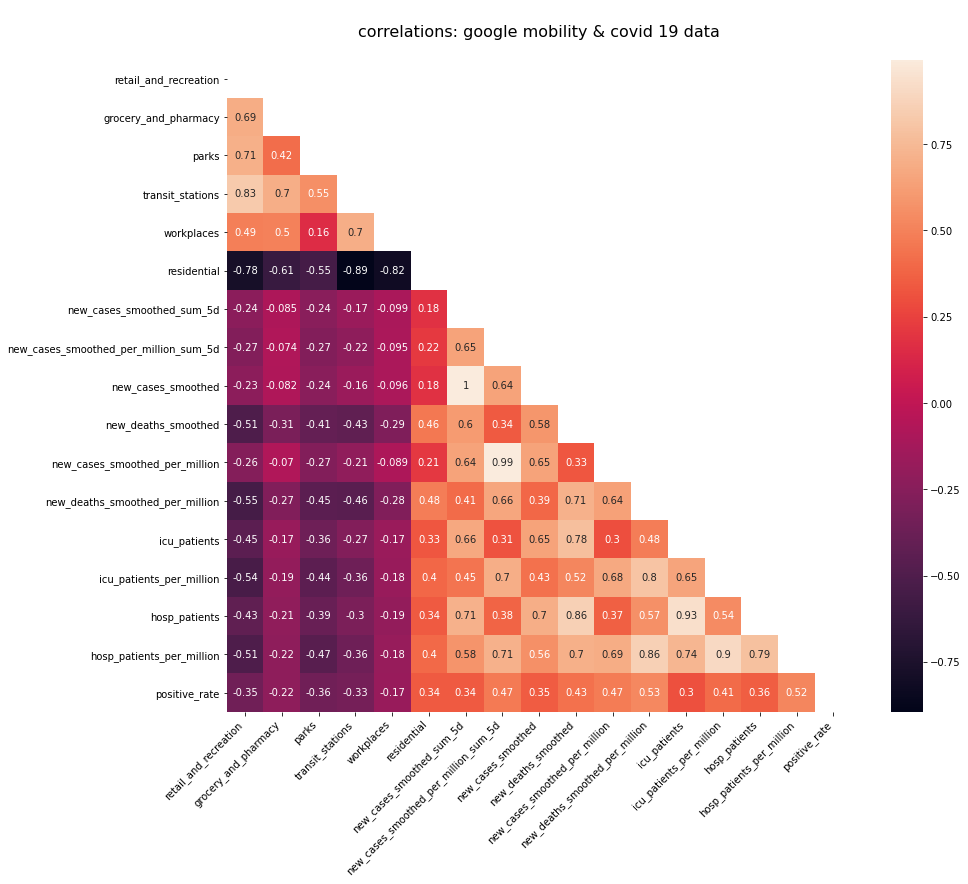

In [71]:
from pyf.eda import show_heatmap

# correlation heatmap
show_heatmap(mobility['all_targets'], 14, 12, title='correlations: google mobility & covid 19 data')


In [72]:
# Paired density and scatterplot matrix

# pgrid_1 = sns.PairGrid(g_mob_covid, diag_sharey=False)
# pgrid_1.map_upper(sns.scatterplot, s=15)
# pgrid_1.map_lower(sns.kdeplot)
# pgrid_1.map_diag(sns.kdeplot, lw=2)

### 3.2.2 facebook mobility data

### 3.2.3 google trends data

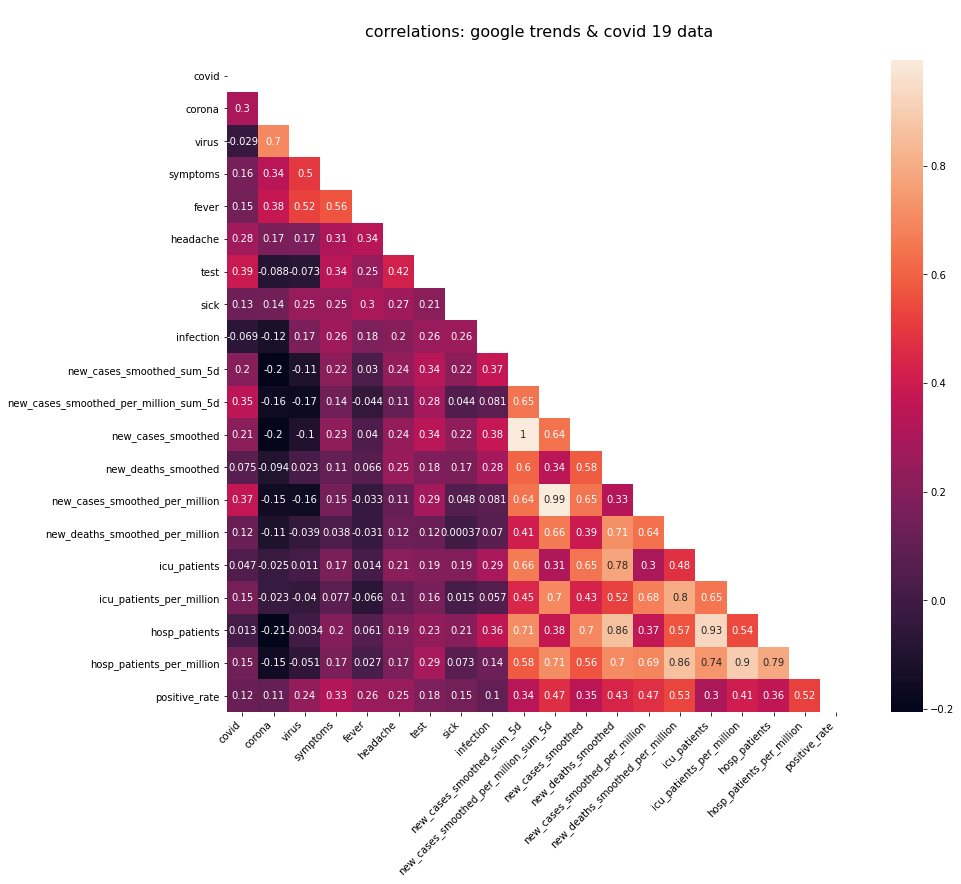

In [73]:
# correlation heatmap
show_heatmap(trends['all_targets'], 14, 12, title='correlations: google trends & covid 19 data')

### 3.2.4 twitter trends data

### 3.2.5 covid 19 data

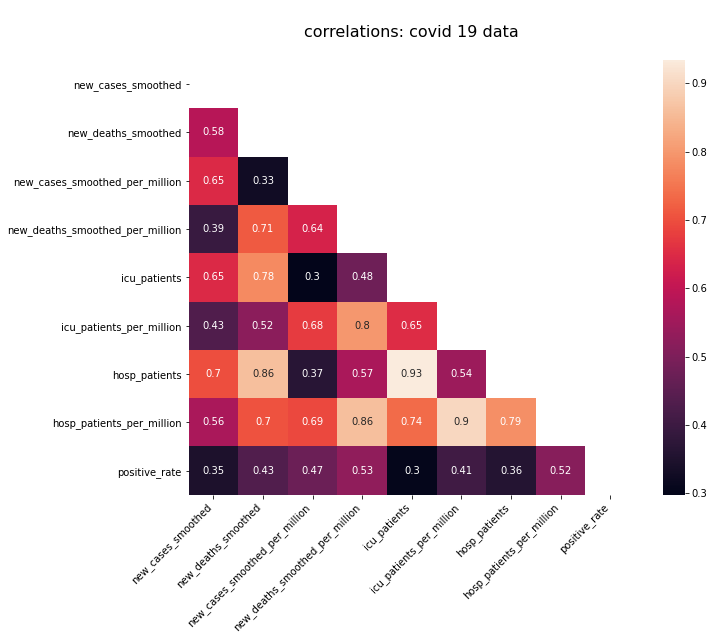

In [74]:
# correlation heatmap
show_heatmap(c19_full, 10, 8, title='correlations: covid 19 data')


### 3.3 visual exploration

### 3.3.1 google mobility data

In [75]:


def plot_timeseries(df, timeframe, w, h, title=''):
    # transform df to get a line for each col
    df = df.melt(timeframe, var_name='columns', value_name='vals')
    # plot
    custom_params = {"axes.spines.right": False, "axes.spines.top": False, "axes.spines.left": False}
    sns.set(rc={'figure.figsize':(w,h)})
    sns.set_theme(style="whitegrid", rc=custom_params)
    sns.lineplot(x=timeframe, y="vals", hue='columns', data=df).set_title('\n' + title + '\n', fontsize=16)
    
    #axes = plt.gca()
    #axes.yaxis.grid()
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks(rotation=45, ha='right')
    plt.show()


# TO DO
# daily > weelky data for plots
# removes v grid lines
# plot in different ways (by country, c19 data only features together with similar scales, ...)
    
    
# Plot the responses for different events and regions




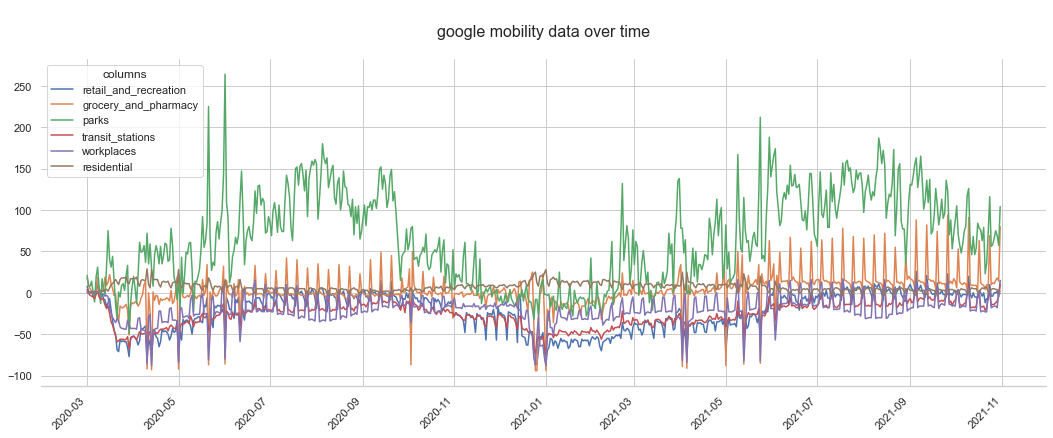

In [76]:
mobility_plotting = data_mobility[data_mobility['location'] == 'DEU']
mobility_plotting = mobility_plotting.drop(['location', 'season'], axis=1)

plot_timeseries(mobility_plotting, 'date', 18, 6, 'google mobility data over time')

### 3.3.2 facebook mobility data

### 3.3.3 google trends data

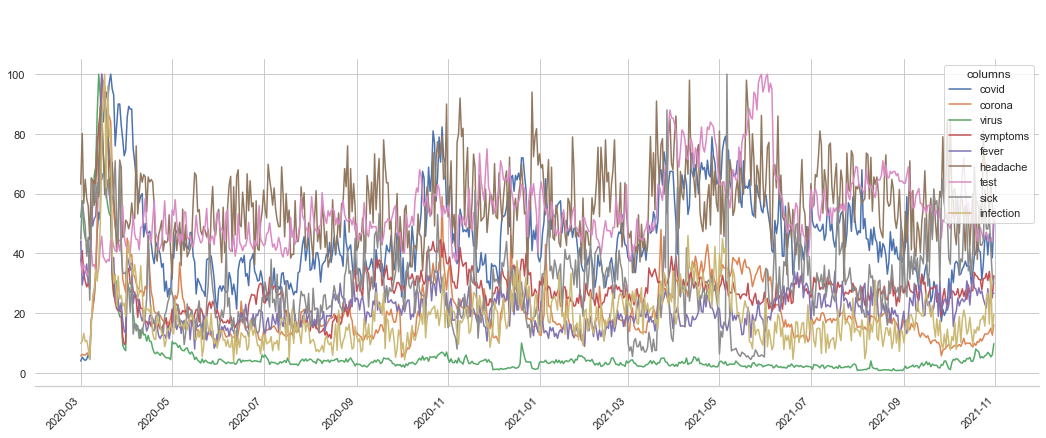

In [77]:
trends_plotting = data_g_trends[data_g_trends['location'] == 'DEU']
trends_plotting = trends_plotting.drop(['location', 'season'], axis=1)

plot_timeseries(trends_plotting, 'date', 18, 6)

### 3.3.4 twitter trends data

### 3.3.5 covid 19 data

**metrics over time**

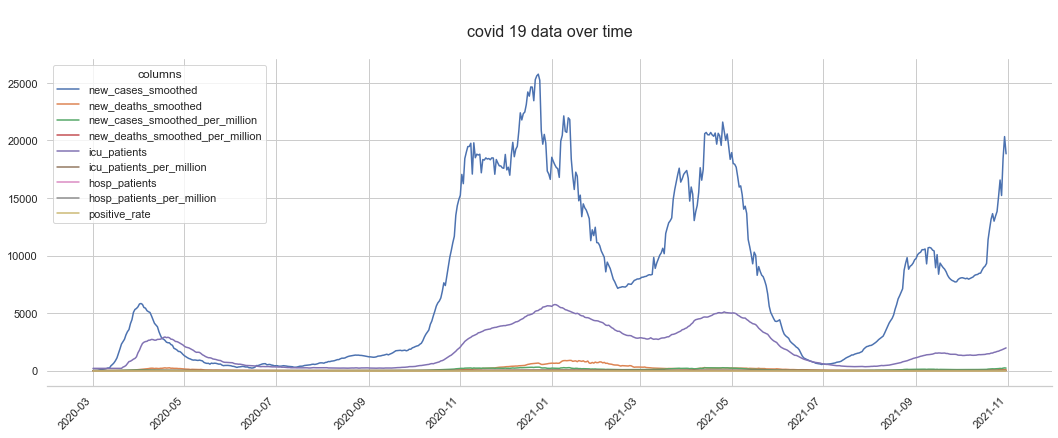

In [78]:
c19_plotting = c19_full[c19_full['location'] == 'DEU']
c19_plotting = c19_plotting.drop(['location'], axis=1)

plot_timeseries(c19_plotting, 'date', 18, 6, 'covid 19 data over time')

**time series decomposition**

In [79]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [80]:
c19_decomp = c19_full[c19_full['location'] == 'ITA']

datetime_index = pd.DatetimeIndex(c19_decomp['date'].values)
c19_decomp.set_index(datetime_index, inplace=True)

c19_decomp.head()


,location,date,new_cases_smoothed,new_deaths_smoothed,new_cases_smoothed_per_million,new_deaths_smoothed_per_million,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,positive_rate
2020-03-01,ITA,2020-03-01,219.857,4.429,3.642,0.073,140.0,2.319,779.0,12.904,0.095
2020-03-02,ITA,2020-03-02,258.143,6.429,4.276,0.106,166.0,2.750,908.0,15.041,0.095
2020-03-03,ITA,2020-03-03,311.429,9.857,5.159,0.163,229.0,3.793,1263.0,20.922,0.126
2020-03-04,ITA,2020-03-04,376.571,13.571,6.238,0.225,295.0,4.887,1641.0,27.184,0.130
2020-03-05,ITA,2020-03-05,457.571,18.714,7.580,0.310,351.0,5.814,2141.0,35.466,0.157


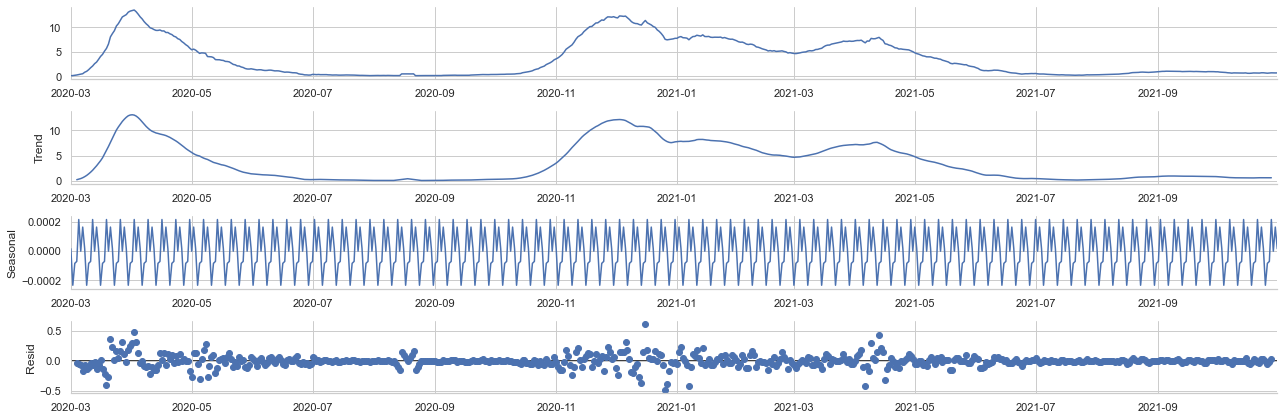

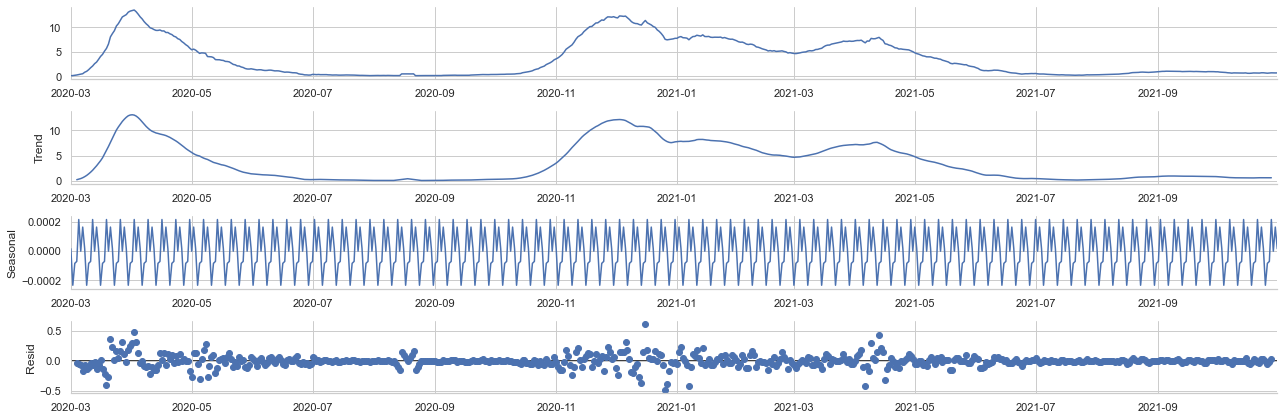

In [81]:
decompose_data = seasonal_decompose(c19_decomp[['new_deaths_smoothed_per_million']], model="additive")
decompose_data.plot()


# 4 | Data preprocessing

### 4.1 Mobility data

### 4.1.1 Feature selection

**feature selection by correlation**

In [82]:


# in case to features have corr above 0.8 eliminate feature with lower corr with target var




**further feature selection**

In [83]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.feature_selection import VarianceThreshold
import statsmodels.api as sm
from pyf.preprocessing import feature_selection_indicators

# check indicators for column variance, multi colinearity (VIF) and p values 
mobility_featind = feature_selection_indicators(mobility['new_cases_smoothed_per_million'], 'new_cases_smoothed_per_million')


In [84]:
mobility_featind

,variance,p value,VIF
const,-,0.000,9.355
retail_and_recreation,686.079855,0.000,5.194
grocery_and_pharmacy,489.274331,0.000,2.244
parks,5809.399452,0.000,2.710
transit_stations,449.104287,0.783,7.022
workplaces,350.751591,0.834,4.932
residential,57.051396,0.770,11.129
new_cases_smoothed_sum_5d,1690973639.371495,0.717,1.752
new_cases_smoothed_per_million_sum_5d,963730.249368,0.000,1.812


**additional selection approaches**

In [85]:
# chi2 test not neccessary because only one cat. feature
# check feat selct form classroom material and mention

### 4.1.2 target variable time lag

In [86]:
from pyf.preprocessing import timeseries_clustered_target_lags

# create different dfs for a lagging target variable between 3 and 21 days
mobility_cases = timeseries_clustered_target_lags(mobility['new_cases_smoothed_per_million'], 'date', 'location', 'new_cases_smoothed_per_million', min_lag=3, max_lag=21)


### 4.1.3 encoding categorical features

In [87]:
from pyf.transform import encoding_get_dummies

# dict to store encoded datasets
mobility_cases_encoded = {}

# encoding categorical col with get dummies
for k, v in mobility_cases.items():
    dataset_encoded = encoding_get_dummies(df=v, drop_first=False)
    mobility_cases_encoded[k] = dataset_encoded


### 4.1.4 train-test-split

In [88]:


# TODO:
# next func for model and scores
# func to filter pred by feat eg. country: recombined x train and test with original df (index has to match) > filter > scores from filtered x and y test and pred (check 7.01)





In [89]:
from sklearn.model_selection import train_test_split
from pyf.models import train_test_split_items

# dict for all resulting dfs
mobility_cases_modeldata = {}

# create train test splits 
for k,v in mobility_cases_encoded.items():
    modeldata = v
    mobility_cases_modeldata[k] = train_test_split_items(df=modeldata, timeframe='date', test_size=0.2, random_state=84, as_timeseries=True)



In [90]:
mobility_cases_modeldata['lag_10']['X_train'].head()

,location_AUT,location_CZE,location_DEU,location_DNK,location_ESP,location_FRA,location_GBR,location_GRC,location_ITA,location_NLD,location_POL,location_PRT,location_SWE,season_fall,season_spring,season_summer,season_winter,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,new_cases_smoothed_sum_5d,new_cases_smoothed_per_million_sum_5d
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,8.0,6.0,1.0,2.0,0.0,16.571,1.832
1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,-19.0,-5.0,-30.0,-26.0,-5.0,4.0,1623.571,26.895
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,21.0,-7.0,-5.0,5.0,1.0,0.0,5.571,0.957
3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,3.0,4.0,2.0,2.0,1.0,0.0,27.287,1.590
4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,7.0,-7.0,30.0,10.0,2.0,1.0,11.430,0.300


### 4.2 trends data

### 4.2.1 feature selection

**feature selection by correlation**

In [91]:


# in case to features have corr above 0.8 eliminate feature with lower corr with target var




**further feature selection**

In [92]:
# check indicators for column variance, multi colinearity (VIF) and p values 
trends_featind = feature_selection_indicators(trends['new_cases_smoothed_per_million'], 'new_cases_smoothed_per_million')


In [93]:
trends_featind

,variance,p value,VIF
const,-,0.000,11.068
covid,336.666282,0.000,1.854
corona,140.6458,0.002,3.019
virus,109.363079,0.093,3.226
symptoms,139.809479,0.000,1.931
fever,161.11642,0.212,1.818
headache,407.93949,0.008,1.400
test,377.292918,0.298,1.733
sick,287.916489,0.727,1.246
infection,476.945157,0.625,1.478


**additional selection approaches**

In [94]:
# chi2 test not neccessary because only one cat. feature

### 4.2.2 target variable time lag

In [95]:
# create different dfs for a lagging target variable between 3 and 14 days
trends_cases = timeseries_clustered_target_lags(trends['new_cases_smoothed_per_million'], 'date', 'location', 'new_cases_smoothed_per_million', min_lag=3, max_lag=14)


### 4.2.3 encoding categorical features

In [96]:
# dict to store encoded datasets
trends_cases_encoded = {}

# encoding categorical col with get dummies
for k, v in trends_cases.items():
    dataset_encoded = encoding_get_dummies(df=v, drop_first=False)
    trends_cases_encoded[k] = dataset_encoded


### 4.2.4 train test split

In [97]:
# dict for all resulting dfs
trends_cases_modeldata = {}

# create train test splits 
for k,v in trends_cases_encoded.items():
    modeldata = v
    trends_cases_modeldata[k] = train_test_split_items(df=modeldata, timeframe='date', test_size=0.2, random_state=84, as_timeseries=True)


# 5 | Baseline model

### 5.1 Baseline model using mobility data

In [98]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

from pyf.models import regression_model_and_evaluation, regression_model_comparison, regression_model_evaluation_metrics, regression_model_evaluation_clustered
    

In [99]:
# create list of model titles
fr_title_list = ['RF_cases_lag' + str(d) for d in range(3,22)]
fr_title_list.insert(0, 'RF_cases_nolag')

# execute models and get metrics
rf_mobility_cases, rf_mobility_cases_comp = regression_model_comparison(datasets=mobility_cases_modeldata, titles=fr_title_list, model_type=RandomForestRegressor)

In [100]:
mobility_cases_modeldata['lag_10']['X_test'].head()

,location_AUT,location_CZE,location_DEU,location_DNK,location_ESP,location_FRA,location_GBR,location_GRC,location_ITA,location_NLD,location_POL,location_PRT,location_SWE,season_fall,season_spring,season_summer,season_winter,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,new_cases_smoothed_sum_5d,new_cases_smoothed_per_million_sum_5d
6240,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,-14.0,-8.0,61.0,-20.0,-41.0,5.0,16932.857,362.236
6241,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,12.0,42.0,148.0,-2.0,-14.0,-3.0,2096.285,202.134
6242,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0.0,13.0,80.0,-20.0,-23.0,2.0,5142.001,85.179
6243,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-15.0,8.0,53.0,-13.0,-14.0,2.0,622.428,68.829
6244,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0.0,12.0,114.0,-34.0,-22.0,6.0,4056.001,236.184


### 5.2 evaluation of mobility data baseline model 

In [101]:
rf_mobility_cases_comp

,model title,R2 (train),R2 (test),R2 adj.,MAE,RMSE,MSE
0,RF_cases_nolag,0.998,0.982,0.982,12.727,20.285,411.492
1,RF_cases_lag3,0.994,0.888,0.886,33.772,50.327,2532.825
2,RF_cases_lag4,0.992,0.839,0.836,41.433,60.524,3663.108
3,RF_cases_lag5,0.991,0.768,0.764,49.847,72.585,5268.634
4,RF_cases_lag6,0.990,0.692,0.687,58.362,83.698,7005.362
5,RF_cases_lag7,0.988,0.603,0.597,67.375,95.036,9031.882
6,RF_cases_lag8,0.988,0.531,0.523,73.710,103.312,10673.431
7,RF_cases_lag9,0.986,0.380,0.370,85.276,118.763,14104.593
8,RF_cases_lag10,0.986,0.270,0.258,94.354,128.976,16634.747
9,RF_cases_lag11,0.986,0.137,0.123,102.989,140.274,19676.821


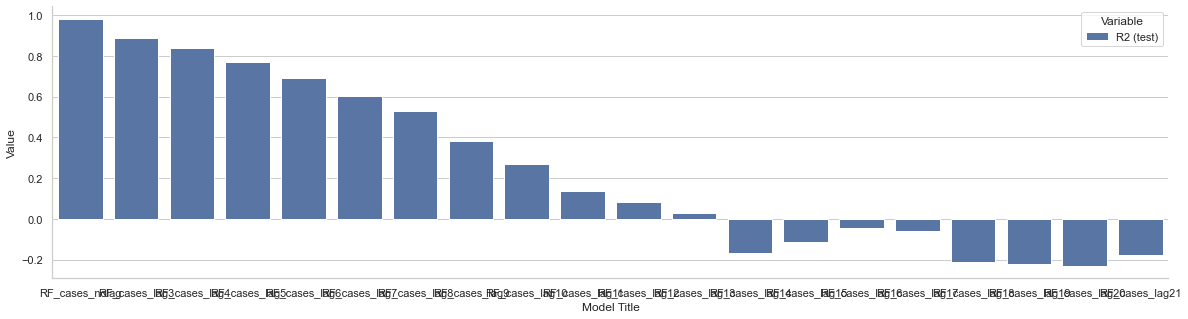

In [102]:
fig, ax1 = plt.subplots(figsize=(20, 5))
tidy = rf_mobility_cases_comp.melt(id_vars='model title').rename(columns=str.title)
tidy = tidy[tidy['Variable'] == 'R2 (test)']
sns.barplot(x='Model Title', y='Value', hue='Variable', data=tidy, ax=ax1)
sns.despine(fig)


In [103]:
# get preformance metrics for 5 days lag clustered by location
lag5_clustered_loc = regression_model_evaluation_clustered(dataset=rf_mobility_cases['lag_5'], cluster_by='location', undummify=True)

In [104]:
lag5_clustered_loc

,model title,location,R2 (train),R2 (test),R2 adj.,MAE,RMSE,MSE
0,RF_cases_lag5,GBR,0.991,-0.373,-0.734,85.521,104.649,10951.447
1,RF_cases_lag5,GRC,0.991,-1.447,-2.091,69.577,85.613,7329.639
2,RF_cases_lag5,AUT,0.991,0.673,0.587,46.025,62.047,3849.849
3,RF_cases_lag5,DNK,0.991,0.280,0.091,34.286,43.533,1895.129
4,RF_cases_lag5,DEU,0.991,0.438,0.290,31.855,40.151,1612.141
5,RF_cases_lag5,PRT,0.991,0.506,0.376,55.907,63.356,4014.030
6,RF_cases_lag5,POL,0.991,0.983,0.979,3.508,5.550,30.797
7,RF_cases_lag5,NLD,0.991,0.066,-0.180,83.445,126.439,15986.871
8,RF_cases_lag5,CZE,0.991,0.885,0.855,15.804,30.451,927.268
9,RF_cases_lag5,SWE,0.991,-0.825,-1.305,25.316,34.815,1212.100


In [105]:
# get preformance metrics for 5 days lag clustered by season
lag5_clustered_season = regression_model_evaluation_clustered(dataset=rf_mobility_cases['lag_5'], cluster_by='season', undummify=True)

In [106]:
lag5_clustered_season

,model title,season,R2 (train),R2 (test),R2 adj.,MAE,RMSE,MSE
0,RF_cases_lag5,summer,0.991,0.758,0.751,47.148,77.589,6020.049
1,RF_cases_lag5,fall,0.991,0.782,0.774,52.979,66.306,4396.454


<AxesSubplot:ylabel='new_cases_smoothed_per_million_lag5'>

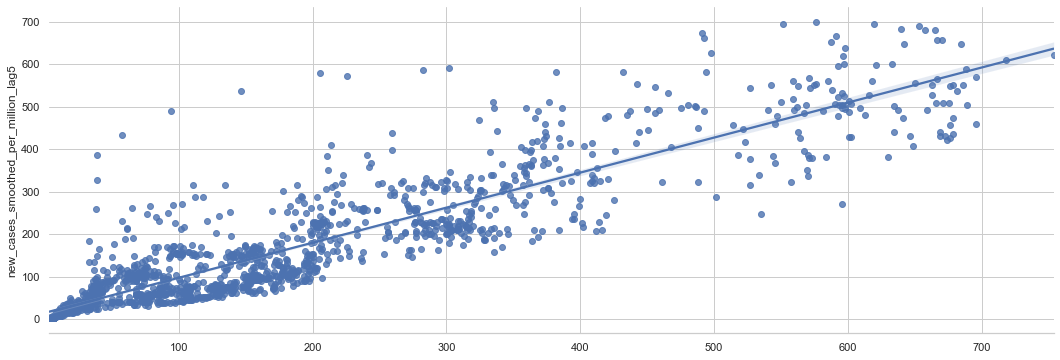

In [107]:
sns.regplot(rf_mobility_cases['lag_5']['predictions'], rf_mobility_cases['lag_5']['y_test'])

### 5.3 Baseline model using google trends data

In [108]:
# create list of model titles for all lags
fr_trends_title_list = ['RF_cases_lag' + str(d) for d in range(3,15)]
fr_trends_title_list.insert(0, 'RF_cases_nolag')

# create models to predict cases per million for all lags 
rf_trends_cases, rf_trends_cases_metrics = regression_model_comparison(datasets=trends_cases_modeldata, titles=fr_title_list, model_type=RandomForestRegressor)


### 5.4 evaluation of mobility data baseline model 

In [109]:
rf_trends_cases_metrics

,model title,R2 (train),R2 (test),R2 adj.,MAE,RMSE,MSE
0,RF_cases_nolag,0.999,0.983,0.983,12.493,19.835,393.414
1,RF_cases_lag3,0.995,0.909,0.907,29.821,45.475,2067.954
2,RF_cases_lag4,0.993,0.867,0.865,36.522,55.048,3030.286
3,RF_cases_lag5,0.993,0.825,0.822,42.556,63.128,3985.195
4,RF_cases_lag6,0.992,0.777,0.773,48.619,71.264,5078.513
5,RF_cases_lag7,0.991,0.718,0.713,55.344,80.069,6410.970
6,RF_cases_lag8,0.989,0.662,0.656,61.100,87.749,7699.825
7,RF_cases_lag9,0.988,0.599,0.592,66.910,95.537,9127.345
8,RF_cases_lag10,0.987,0.518,0.509,74.035,104.851,10993.632
9,RF_cases_lag11,0.987,0.444,0.434,80.009,112.582,12674.611


In [110]:
# sns.regplot(preds, y_test)

# 6 | Mobility data model improvements

### 6.1. Feature transformations

### 6.1.1. Feature scaling

In [111]:
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler
from pyf.transform import scaling_model_dataset, invert_scaling_model_dataset

# copy dataset for scaling
mob_test = mobility_cases_modeldata['lag_7'].copy()
mob_scale_columns = ['retail_and_recreation','grocery_and_pharmacy','parks','transit_stations','workplaces','residential']

# scaling features
mob_test = scaling_model_dataset(dataset=mob_test, title='minmax_x', in_columns=mob_scale_columns, transformer_type=MinMaxScaler, target=False)

# scaling target var
mob_test = scaling_model_dataset(dataset=mob_test, title='minmax_y', transformer_type=MinMaxScaler, target=True)

# model with scaled data and get evaluation metrics
rf_scaled, rf_scaled_metrics = regression_model_and_evaluation(dataset=mob_test, title='RF_cases_lag7 (scaled)', model_type=RandomForestRegressor)


In [112]:
# performance pre scaling
rf_mobility_cases_comp[rf_mobility_cases_comp['model title'] == 'RF_cases_lag7']


,model title,R2 (train),R2 (test),R2 adj.,MAE,RMSE,MSE
5,RF_cases_lag7,0.988,0.603,0.597,67.375,95.036,9031.882


In [113]:
# performance after scaling
rf_scaled_metrics


,model title,R2 (train),R2 (test),R2 adj.,MAE,RMSE,MSE
0,RF_cases_lag7 (scaled),0.988,0.607,0.601,0.05,0.071,0.005


In [114]:
mob_unscale = mob_test.copy()

# unscaling features
# mob_unscale = invert_scaling_model_dataset(dataset=mob_unscale, in_columns=mob_scale_columns, load_transformer=stdsc_1, target=False)

# unscaling target var
# mob_unscale = invert_scaling_model_dataset(dataset=mob_unscale, load_transformer=minmax_1, target=True)

# mob_unscale['X_test'].head()

### 6.1.2. Boxcox transformation

In [115]:
# boxcox transformation applied to a model dataset dict 
# take inputs: dataset, in_columns=col to transform (list, optional, default=all num col), skip=col not to transform if in_columns is default (list, optional), 
# target=choose btw. boxcox of features or target var (bool, default=False), title=pick name for dict key to add transformer (str)
# outputs: df with transformations
def boxcox_model_dataset(dataset, title, in_columns=[], skip=[], target=False):
    # create dataset copy for results
    dataset_boxcox = dataset.copy()
    
    # case: boxcox features
    if target == False:
        # boxcox training set
        dataset_boxcox['X_train'], _bxcx = boxcox_transform(df=dataset_boxcox['X_train'], columns=in_columns, skip=skip)
        # boxcox test set
        dataset_boxcox['X_test'], _bxcx = boxcox_transform(df=dataset_boxcox['X_test'], columns=in_columns, skip=skip, fit=_bxcx)
    
    # case: boxcox target var
    else:
        # boxcox training set
        dataset_boxcox['y_train'], _bxcx = boxcox_transform(df=dataset_boxcox['y_train'], columns=in_columns, skip=skip)
        # boxcox test set
        dataset_boxcox['y_test'], _bxcx = boxcox_transform(df=dataset_boxcox['y_test'], columns=in_columns, skip=skip, fit=_bxcx)

    # add sckler to dict
    dataset_boxcox[title] = _bxcx
        
    return dataset_boxcox



# apply boxcox transformation to df
# inputs: df, columns=col to boxcox (list, optional, default=all num col), skip=col not to boxcox (list, optional, default=[]),
# fit=secify already existing transformer (default='', optional)  
# outputs: transformed df, transformer
def boxcox_transform(df, columns=[], skip=[], fit=''):
    if columns == []:
        columns = df.select_dtypes(np.number).columns
    _ci = {column: None for column in columns}
    
    for column in columns:
        if column not in skip:
            df[column] = np.where(df[column]<=0, np.NAN, df[column]) 
            df[column] = df[column].fillna(df[column].median())
            if fit == '':
                transformed_data, ci = stats.boxcox(df[column])
                df[column] = transformed_data
                _ci[column] = [ci] 
            else:
                transformed_data = stats.boxcox(df[column], fit[column])
                _ci = fit
    return df, _ci

In [116]:
# from pyf.transform import boxcox_model_dataset

# copy dataset for boxcox
mob_boxcox = mob_test.copy()
mob_boxcox_columns = ['retail_and_recreation','grocery_and_pharmacy','parks','transit_stations','workplaces','residential']


In [120]:
from pyf.eda import plots_continuous_var

# value distribution before boxcox transformation
plots_continuous_var(mob_boxcox['X_train'], in_columns=mob_boxcox_columns)


ImportError: cannot import name 'plots_continuous_var' from 'pyf.eda' (/Users/kevin/Documents/DataScienceCourse/2_CourseWork/Project_Final/P03-how-to-predict-a-pandemic/pyf/eda.py)

In [124]:
# boxcox transformation
mob_boxcox = boxcox_model_dataset(mob_boxcox, in_columns=mob_boxcox_columns, title='RF_cases_lag7 (boxcox)')


In [125]:
# model with boxcox transformed data and get evaluation metrics
rf_boxcox, rf_boxcox_metrics = regression_model_and_evaluation(dataset=mob_boxcox, title='RF_cases_lag7 (boxcox)', model_type=RandomForestRegressor)


In [ ]:
plots_continuous_var(mob_boxcox['X_train'], columns=mob_boxcox_columns)


In [126]:
# performance before boxcox
rf_scaled_metrics

,model title,R2 (train),R2 (test),R2 adj.,MAE,RMSE,MSE
0,RF_cases_lag7 (scaled),0.988,0.607,0.601,0.05,0.071,0.005


In [127]:
rf_boxcox_metrics

,model title,R2 (train),R2 (test),R2 adj.,MAE,RMSE,MSE
0,RF_cases_lag7 (boxcox),0.988,0.587,0.58,0.053,0.073,0.005


### 6.1.3. Handling outliers

In [ ]:
# no outlier handeling because they are important

### 6.2. Hyperparameter tuning

In [135]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score

# define possible parameters
params = {'max_depth': [5,9, None], 'n_estimators':[50, 100, 400], 
         'max_features': ['auto', 'sqrt'], 'min_samples_leaf': [1, 2, 4]}

# perform grid serach to find the best parameters for RandomForest
rf_grid_search = GridSearchCV(RandomForestRegressor(random_state=11), params, cv=10, return_train_score=True, n_jobs=-1)
rf_grid_search.fit(mob_test['X_train'],mob_test['y_train'])

# perform randomized serach to find the best parameters for RandomForest
# rnd_search = RandomizedSearchCV(RandomForestRegressor(random_state=11), params, n_iter=16, cv=10)
# rnd_search.fit(mob_test['X_train'],mob_test['y_train'])


GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=11), n_jobs=-1,
             param_grid={'max_depth': [5, 9, None],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'n_estimators': [50, 100, 400]},
             return_train_score=True)

In [137]:
rf_grid_search.best_params_
#rf_grid_search.best_score_

# rnd_search.best_params_
# rnd_search.best_score_


{'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'n_estimators': 50}

In [ ]:
# cross validaton
rf = RandomForestRegressor(random_state=11, max_depth=, max_features='sqrt', min_samples_leaf=1, n_estimators=100)
cross_val_scores = cross_val_score(clf, mob_test['X_train'], mob_test['y_train'], cv=10)
print(np.mean(cross_val_scores))


### 6.3. alternative model algoritms

### 6.3.1. ARIMA model

To perform forecasting using the ARIMA model, we required a stationary time series. Stationary time series is a time series that is unaffected by the four components observed in the EDA. If the data is not stationary, we can either make the data stationary or use the SARIMAX model.

To know more about the time series stationarity, we can perform the ADfuller test, a test based on hypothesis, where if the p-value is less than 0.05, then we can consider the time series is stationary, or non-stationary if the p-value is greater than 0.05.

**ADfuller test**

In [ ]:
from statsmodels.tsa.stattools import adfuller

adft = adfuller(c19_decomp[['new_deaths_smoothed_per_million']], autolag = 'AIC')
print("1. ADF : ",adft[0])
print("2. P-Value : ", adft[1])
print("3. Num Of Lags : ", adft[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", adft[3])
print("5. Critical Values :")
for key, val in adft[4].items():
    print("\t",key, ": ", val)


Here we can see that the p-value is higher than 0.05, meaning that the evidence for the null hypothesis is low. Hence the time series is non-stationary. 

**Data preprocessing for ARIMA model**

In [ ]:
# copy dataset 
mobility_cases_encoded_lag7 = mobility_cases_encoded['lag_7'].copy()

# subset for example case germany
mobility_cases_encoded_lag7 = mobility_cases_encoded_lag7[mobility_cases_encoded_lag7['location_ESP'] == 1]

# drop encoded location columns
location_columns = [col for col in mobility_cases_encoded_lag7.columns if col.startswith('location_') == True]
mobility_cases_encoded_lag7 = mobility_cases_encoded_lag7.drop(location_columns, axis=1)

# convert index to datetime index
datetime_index = pd.DatetimeIndex(mobility_cases_encoded_lag7['date'].values)
mobility_cases_encoded_lag7.set_index(datetime_index, inplace=True)

# x-y-split 
X_arima = mobility_cases_encoded_lag7.iloc[:, :-1].drop(['date'], axis=1)
y_arima = mobility_cases_encoded_lag7.drop(mobility_cases_encoded_lag7.iloc[:, :-1], axis=1)

# train-test-split
train_size = int(len(mobility_cases_encoded_lag7) * 0.8)
test_size = int(len(mobility_cases_encoded_lag7)) - train_size

train_X_arima, train_y_arima = X_arima[:train_size], y_arima[:train_size]
test_X_arima, test_y_arima = X_arima[train_size:], y_arima[train_size:]

mobility_lag7_arima = {'X_train': train_X_arima, 'X_test': test_X_arima, 'y_train': train_y_arima, 'y_test': test_y_arima}

# feature and target scaling with MinMaxSclaer
mobility_lag7_scaled_arima = mobility_lag7_arima.copy()

minmax_columns = ['retail_and_recreation', 'grocery_and_pharmacy', 'parks', 'transit_stations', 'workplaces', 'residential', 'new_cases_smoothed_sum_5d', 'new_cases_smoothed_per_million_sum_5d']
mobility_lag7_scaled_arima = scaling_model_dataset(dataset=mobility_lag7_scaled_arima, title='minmax_x', in_columns=minmax_columns, transformer_type=MinMaxScaler, target=False)
mobility_lag7_scaled_arima = scaling_model_dataset(dataset=mobility_lag7_scaled_arima, title='minmax_y', transformer_type=MinMaxScaler, target=True)


**Finding best ARIMA model**

The auto_arima function fits the best ARIMA model to the time series data. Pyramid auto Arima performs a stepwise search for AR and MA term, meaning possible model & seasonal orders based on the chosen parameters. It selects the parameters that minimize the given metric like AIC (Akaike Information Criterion).

In [ ]:
from pmdarima.arima import auto_arima

step_wise=auto_arima(train_y_arima, 
 exogenous= train_X_arima,
 start_p=1, start_q=1, 
 max_p=7, max_q=7, 
 d=1, max_d=7,
 trace=True, 
 error_action='ignore', 
 suppress_warnings=True, 
 stepwise=True)

step_wise.summary()

**ARIMA model**

In [122]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf

# apply model
model = ARIMA(train_y_arima, exog=train_X_arima, order=(1,1,2))

# model fit
arima_112 = model.fit()

# create predictions
forecast_1, se, conf = arima_112.forecast(steps=test_size ,exog=test_X_arima)
forecast_1 = pd.DataFrame(forecast_1)
forecast_1
forecast_1.reset_index(drop=True, inplace=True)
forecast_1.index = test_X_arima.index
forecast_1.rename(columns={0:'pred'}, inplace=True)
forecast_1['actual'] = test_y_arima['new_cases_smoothed_per_million_lag7']


NameError: name 'train_y_arima' is not defined

**Accuracy metrics**

In [ ]:
def arima_forecast_accuracy_metrics(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))
    corr = np.corrcoef(forecast, actual)[0,1]
    mins = np.amin(np.hstack([forecast[:,None], actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)
    me = np.mean(forecast - actual)
    mae = np.mean(np.abs(forecast - actual))
    mpe = np.mean((forecast - actual)/actual)
    rmse = np.mean((forecast - actual)**2)**.5
    acf1 = acf(forecast - actual)[1]
    
    # create metrics df
    results = pd.DataFrame({'mape': [mape], 'corr': [corr], 'minmax': [minmax], 'me': [me], 'mae': [mae], 'mpe': [mpe], 'rmse': [rmse], 'acf1': [acf1]})
    
    return results

forecast_1_metrics = arima_forecast_accuracy_metrics(forecast_1['pred'], forecast_1['actual'])
forecast_1_metrics

**Prediction plot**

In [ ]:
forecast_1['actual'].plot(figsize=(20,8), legend=True, color='grey')
forecast_1['pred'].plot(legend=True, color='red', figsize=(20,8))

**SARIMAX model**

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# apply model
model = SARIMAX(train_y_arima, exog=train_X_arima, order=(0,1,0), enforce_invertibility=False, enforce_stationarity=False)

# model fit
sarimax_010 = model.fit()

# create predictions
forecast_2 = sarimax_010.forecast(steps=test_size ,exog=test_X_arima)
forecast_2 = pd.DataFrame(forecast_1)
forecast_2
forecast_2.reset_index(drop=True, inplace=True)
forecast_2.index = test_X_arima.index
forecast_2.rename(columns={0:'pred'}, inplace=True)
forecast_2['actual'] = test_y_arima['new_cases_smoothed_per_million_lag7']


In [ ]:
forecast_2['actual'].plot(figsize=(20,8), legend=True, color='grey')
forecast_2['pred'].plot(legend=True, color='red', figsize=(20,8))

### 6.3.2 XGBoost

In [142]:
# create list of model titles for all lags
xgb_title_list = ['XGB_cases_lag' + str(d) for d in range(3,22)]
xgb_title_list.insert(0, 'XGB_cases_nolag')

# create models to predict cases per million for all lags 
xgb_mobility_cases, xgb_mobility_cases_metrics = regression_model_comparison(datasets=mobility_cases_modeldata, titles=xgb_title_list, model_type=XGBRegressor, random_state=11)

In [143]:
# performance metrics
xgb_mobility_cases_metrics


,model title,R2 (train),R2 (test),R2 adj.,MAE,RMSE,MSE
0,XGB_cases_nolag,0.999,0.975,0.975,14.811,23.914,571.882
1,XGB_cases_lag3,0.997,0.869,0.867,34.495,54.468,2966.750
2,XGB_cases_lag4,0.996,0.815,0.812,43.236,64.785,4197.137
3,XGB_cases_lag5,0.996,0.731,0.727,51.834,78.213,6117.249
4,XGB_cases_lag6,0.995,0.691,0.686,56.587,83.861,7032.686
5,XGB_cases_lag7,0.994,0.539,0.532,68.462,102.403,10486.370
6,XGB_cases_lag8,0.993,0.481,0.473,75.276,108.658,11806.500
7,XGB_cases_lag9,0.993,0.198,0.185,94.204,135.038,18235.345
8,XGB_cases_lag10,0.993,0.286,0.274,90.596,127.584,16277.665
9,XGB_cases_lag11,0.992,0.276,0.264,92.320,128.508,16514.275


In [144]:
# get preformance metrics for 6 days lag clustered by location
mobility_cases_lag6_xgb_clustered = regression_model_evaluation_clustered(dataset=xgb_mobility_cases['lag_6'], cluster_by='location', undummify=True)

In [145]:
mobility_cases_lag6_xgb_clustered

,model title,location,R2 (train),R2 (test),R2 adj.,MAE,RMSE,MSE
0,XGB_cases_lag6,POL,0.995,0.962,0.952,5.705,8.275,68.472
1,XGB_cases_lag6,FRA,0.995,0.400,0.242,71.249,86.935,7557.702
2,XGB_cases_lag6,ITA,0.995,-1.339,-1.955,38.762,43.694,1909.183
3,XGB_cases_lag6,DEU,0.995,0.580,0.469,27.816,34.746,1207.286
4,XGB_cases_lag6,CZE,0.995,0.854,0.816,18.495,34.285,1175.471
5,XGB_cases_lag6,NLD,0.995,-0.022,-0.291,85.046,132.321,17508.937
6,XGB_cases_lag6,ESP,0.995,0.653,0.562,87.818,106.761,11397.908
7,XGB_cases_lag6,SWE,0.995,-1.438,-2.080,30.153,40.243,1619.536
8,XGB_cases_lag6,GBR,0.995,-2.158,-2.989,129.987,158.709,25188.425
9,XGB_cases_lag6,PRT,0.995,0.265,0.072,65.393,77.283,5972.731


### 6.4. alternative target variables

### 6.5. comparing models

### 6.6. Evaluating best model in detail

# 7 | Google trends data models improvements

### 7.1. model improvements

### 7.1.1. feature transformations

### 7.1.2. handling outliers

### 7.1.2. hyperparameter tuning

### 7.2. model algorithms 

### 7.2.1. Random Forrest 

### 7.2.2 XGBoost

### 7.2.3. ARIMA model

### 7.3. comparing models

### 7.4 detailed evaluation